In [5]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
sns.set(style='ticks', context='talk', font='CMU Sans Serif')

In [6]:
mix_id = 1
mix_dir = f'../data/{mix_id}'
df_ns3 = pd.read_csv(f'{mix_dir}/ns3/records.csv').sample(n=2_000_000)
df_pmn_m = pd.read_csv(f'{mix_dir}/pmn-m/records.csv').sample(n=2_000_000)
df_pmn_mc = pd.read_csv(f'{mix_dir}/pmn-mc/records.csv').sample(n=2_000_000)
df = pd.concat([df_ns3, df_pmn_m, df_pmn_mc], ignore_index=True)
df.loc[df['size'] < 10_000, 'bin'] = 'Smaller than 10 KB'
df.loc[(10_000 <= df['size']) & (df['size'] < 100_000), 'bin'] = '10 KB to 100 KB'
df.loc[(100_000 <= df['size']) & (df['size'] <= 1_000_000), 'bin'] = '100 KB to 1 MB'
df.loc[1_000_000 < df['size'], 'bin'] = 'Larger than 1 MB'
df['pct'] = df.groupby(by=['sim', 'bin'], as_index=False)['slowdown'].rank(pct=True)

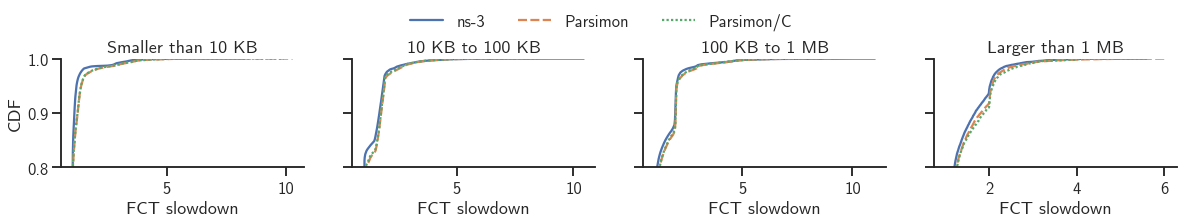

In [7]:
fig, axs = plt.subplots(nrows=1, ncols=4, figsize=(20, 2), sharey=True)
for i, bin in enumerate(['Smaller than 10 KB', '10 KB to 100 KB', '100 KB to 1 MB', 'Larger than 1 MB']):
    ax = sns.lineplot(x='slowdown', y='pct', hue='sim', style='sim', data=df[df['bin'] == bin], ax=axs[i], ci=None)
    ax.set_title(f'{bin}')
    ax.set_ylim((0.8, 1.0))
    ax.set_xlabel('FCT slowdown')
    ax.set_ylabel('CDF')
    handles = ax.get_legend().get_lines()
    ax.get_legend().remove()
# XXX: This is a dirty hack. Comment the above line to check handles and labels match up before doing anything.
fig.legend(handles=handles, labels=['ns-3', 'Parsimon', 'Parsimon/C'], loc='upper center', frameon=False, ncol=4, bbox_to_anchor=(0.5, 1.3))
sns.despine()
plt.savefig('figs/large-scale.pdf', bbox_inches='tight')


In [8]:
# dont' sample for numbers
df_ns3 = pd.read_csv(f'{mix_dir}/ns3/records.csv')
df_pmn_m = pd.read_csv(f'{mix_dir}/pmn-m/records.csv')
df_pmn_mc = pd.read_csv(f'{mix_dir}/pmn-mc/records.csv')
p99_ns3 = df_ns3['slowdown'].quantile(q=0.99)
p99_pmn_m = df_pmn_m['slowdown'].quantile(q=0.99)
p99_pmn_mc = df_pmn_mc['slowdown'].quantile(q=0.99)
print((p99_pmn_m - p99_ns3) / p99_ns3)
print((p99_pmn_mc - p99_ns3) / p99_ns3)